# Exploring Movie Industry Insights for Microsoft Movie Studio

## Overview

This project analyzes performance of over 1,000 major motion pictures over the last decade. Descriptive analysis of budget, revenue and profit data shows that certain movie genres can be expected to perform better at the box office. Microsoft's new movie studio can use this analysis to set budgets as well as make resource allocation decisions to get the most out of their new investment.

## Business Problem

Microsoft has decided to create a new movie studio, and wishes to find out more about the industry. We are charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights.

## Data Understanding

In this section we explore data that will be used in this analysis. Our data comes from two sources:

* [IMDB](https://www.imdb.com/)
* [The Numbers](https://www.the-numbers.com/)

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

In [2]:
# We will be working primarily with two datasets.
# The first is a CSV taken from The Numbers
movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

In [3]:
# The other data source is a SQLite database from the Internet Movie Database (IMDB).
conn = sqlite3.connect('data/im.db')

### The IMDB Data
The IMDB data is composed of 8 different tables. Below is its ERD.

![IMDB ERD](images/imdb_erd.jpeg)

This dataset is the most robust and contains more information than we need. A quick look at the movie_basics table shows us that the dataset contains information on 146,144 unique records between the years of 2010 and 2115 (which is either an error or at the very least something to look into when we do data cleaning).

Looking at the other tables in the database, it looks like we also have information on each movie's: staff (actors, producers, writers, etc.), names of characters played by actors, some basic information on the people involved (like birth year and year of death), as well as info on movie ratings.


In [4]:
q = """
SELECT MIN(start_year), MAX(start_year), COUNT(DISTINCT movie_id)
FROM movie_basics
;"""

pd.read_sql(q, conn)

,MIN(start_year),MAX(start_year),COUNT(DISTINCT movie_id)
0,2010,2115,146144


In [5]:
q = """
SELECT *
FROM movie_basics
LIMIT 10
;"""

pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


### Movie Budgets Data

The movie budgets data comes from The-Numbers.com. It contains records on 5,698 unique movie titles between the years of 1915 and 2020. For each movie, it provides us with the movie's release date, its title, its production budget, and its foreign and domestic box office earnings.

In [6]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
# How many unique movie titles are in the dataset?
movie_budgets['movie'].nunique()

5698

In [9]:
# Get the range of years in the box office dataset

movie_budgets['year'] = movie_budgets['release_date'].str[-4:]

print('The data sets begins in the year:', movie_budgets['year'].min())
print('The dataset contains data on movies through the year: ', movie_budgets['year'].max())

The data sets begins in the year: 1915
The dataset contains data on movies through the year:  2020


## Data Preparation

In this section we set out to prepare our two datasets and to get them in working order so that we can carry out analysis.

### Data Cleaning

#### Cleaning & Preparing movie_budgets

Let's first take a closer look at movie_budgets. Initially, it looks like the dataset has no misisng values.

In [10]:
movie_budgets.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
year                 0
dtype: int64

However, just because it doesn't have Null values doesn't mean some values don't have a placeholder. So we'll investigate this dataset more closely to spot placeholder values.

In [11]:
movie_budgets['release_date'].value_counts().sort_values(ascending=False)

Dec 31, 2014    24
Dec 31, 2015    23
Dec 31, 2010    15
Dec 31, 2008    14
Dec 31, 2013    13
                ..
May 23, 2003     1
Jul 17, 1998     1
Aug 22, 1973     1
Jul 26, 2002     1
Nov 15, 1991     1
Name: release_date, Length: 2418, dtype: int64

In [12]:
movie_budgets['movie'].value_counts().sort_values(ascending=False)

King Kong                       3
Home                            3
Halloween                       3
20,000 Leagues Under the Sea    2
Ben-Hur                         2
                               ..
Jupiter Ascending               1
Forever My Girl                 1
The Professor and the Madman    1
The Great Raid                  1
The Legend of Hercules          1
Name: movie, Length: 5698, dtype: int64

In [13]:
movie_budgets['production_budget'].value_counts().sort_values(ascending=False)

$20,000,000     231
$10,000,000     212
$30,000,000     177
$15,000,000     173
$25,000,000     171
               ... 
$11,800,000       1
$9,000            1
$1,070,000        1
$425,000,000      1
$430,000          1
Name: production_budget, Length: 509, dtype: int64

In [14]:
movie_budgets['worldwide_gross'].value_counts().sort_values(ascending=False)

$0             367
$8,000,000       9
$7,000,000       6
$2,000,000       6
$4,000,000       4
              ... 
$9,370,285       1
$23,266,821      1
$92,494,381      1
$19,859,167      1
$1,412,799       1
Name: worldwide_gross, Length: 5356, dtype: int64

worldwide_gross has 367 occurrences of $0. That's the only unusual high count occurrence. Let's take a look at those records.

In [15]:
movie_budgets_zero = movie_budgets.loc[movie_budgets['worldwide_gross'] == '$0']

movie_budgets_zero

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,"$150,000,000",$0,$0,2020
479,80,"Dec 13, 2017",Bright,"$90,000,000",$0,$0,2017
480,81,"Dec 31, 2019",Army of the Dead,"$90,000,000",$0,$0,2019
535,36,"Feb 21, 2020",Call of the Wild,"$82,000,000",$0,$0,2020
670,71,"Aug 30, 2019",PLAYMOBIL,"$75,000,000",$0,$0,2019
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,"$15,000",$0,$0,2014
5764,65,"Dec 31, 2007",Tin Can Man,"$12,000",$0,$0,2007
5771,72,"May 19, 2015",Family Motocross,"$10,000",$0,$0,2015
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018


Some of the above results are streaming releases, meaning they never had a box office. There, a value of 0 makes sense. This applies, for example, to Bright. However, for other movies the data is just missing. For example, a quick online search shows that Army of the Dead (released Dec 31, 2019) made $1 million at the Box Office.

Since this is just 367 rows out of 5,782 I'm deciding to simply drop these rows.

In [16]:
movie_budgets.drop(movie_budgets[movie_budgets.worldwide_gross == '$0'].index, inplace=True)

Next, notice that the 'production_budget', 'domestic_gross' and 'worldwide_gross' are stored as objects. This will be inconvenient later on when we wish to run calculations on our dataset. It will be helpful to convert these from objects to floats.

In [17]:
movie_budgets[movie_budgets.columns[3:]] = movie_budgets[
    movie_budgets.columns[3:]].replace('[\$,]', 
    '', regex=True).astype(float)

In [18]:
# Confirming the conversion was successful
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5415 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5415 non-null   int64  
 1   release_date       5415 non-null   object 
 2   movie              5415 non-null   object 
 3   production_budget  5415 non-null   float64
 4   domestic_gross     5415 non-null   float64
 5   worldwide_gross    5415 non-null   float64
 6   year               5415 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 338.4+ KB


Lastly, we want to only analyze non-indie films and focus on big productions. Given Microsoft is a multi-billion dollar company we want to make sure we're comparing apples to apples and looking at the types of productions that would make an impact to Microsoft's bottom line.

[This website](https://newbiefilmschool.com/average-low-budget-film-cost/) shows that, on average, indie films have a budget of $2 million. So we'll filter those out of our movie_budgets dataframe

In [19]:
movie_budgets = movie_budgets.loc[movie_budgets['production_budget'] > 2000000]

In [20]:
# Here we make the movie column all lowercase and make a few replacements to help merging later on.

movie_budgets['movie'] = movie_budgets['movie'].str.lower()
movie_budgets['movie'] = movie_budgets['movie'].str.replace(r'\.', '')
movie_budgets['movie'] = movie_budgets['movie'].str.replace(r'\ ep ', ' episode ')

#### Cleaning & Preparing IMDB Data

Next, let's prepare the IMDB data we want to use in our analysis by passing everything we need into a dataframe.

The information we're interested in is a movie's genre, director, the year of release and its title.

454 records have a NULL value for 'genres'. Since this is a descriptive datapoint and not numeric, our option is really to just drop it for now and come back to this if it creates issues down the line.

In [21]:
# Here is how I spotted the 454 NULL genre records

q = """
SELECT *
FROM movie_basics AS mb
JOIN directors AS d
USING(movie_id)
JOIN movie_akas AS akas
USING(movie_id)
JOIN persons AS p
USING(person_id)
WHERE genres IS NULL
AND region == "US"
GROUP BY movie_id
;"""

pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,ordering,title,region,language,types,attributes,is_original_title,primary_name,birth_year,death_year,primary_profession
0,tt0306058,Second Coming,Second Coming,2012,95.0,None,nm0132363,1,Second Coming,US,None,None,None,0.0,Darren Campbell,NaN,NaN,"actor,writer,director"
1,tt0326592,The Overnight,The Overnight,2010,88.0,None,nm1208371,1,"A Bellman, a Hooker, and a Rabbi...",US,None,working,None,0.0,Jed I. Goodman,NaN,NaN,"camera_department,writer,producer"
2,tt10341642,One Hundred and Twenty-Eight Thousand,Sto dvacet osm tisíc,2019,16.0,None,nm10698460,3,One Hundred and Twenty-Eight Thousand,US,None,imdbDisplay,None,0.0,Ondrej Erban,NaN,NaN,director
3,tt10387818,Centurion XII,Centurion XII,2020,NaN,None,nm0327466,1,Centurion the Dancing Stallion,US,None,working,None,0.0,Dana Gonzales,1963.0,NaN,"camera_department,cinematographer,producer"
4,tt1077070,Underground,ASD. Alma sin dueño,2010,NaN,None,nm0328500,3,Underground,US,None,None,new title,0.0,Tinieblas González,1972.0,NaN,"director,writer,editor"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,tt8394036,Postpartum Depression Awareness PSA,Postpartum Depression Awareness PSA,2016,NaN,None,nm6789992,1,Postpartum Depression Awareness PSA,US,None,None,None,0.0,Joshua Friese,NaN,NaN,"cinematographer,director,producer"
450,tt9041234,Lost and Found,Je promets d'être sage,2019,NaN,None,nm1398405,1,Lost and Found,US,None,imdbDisplay,None,0.0,Ronan Le Page,NaN,NaN,"director,writer"
451,tt9118844,$MOKE,$MOKE,2019,NaN,None,nm1622543,1,$MOKE,US,None,None,None,0.0,Greg Galloway,NaN,NaN,"producer,director,writer"
452,tt9196212,A Rising Tide of Silence,A Rising Tide of Silence,2013,75.0,None,nm10220497,2,Thomas Keating: A Rising Tide of Silence,US,None,None,complete title,0.0,Peter C. Jones,NaN,NaN,"director,writer,producer"


In [22]:
# Creating a dataframe with the IMDB data

q = """
SELECT movie_id, mb.original_title AS title, mb.genres, mb.start_year AS year, p.primary_name AS director
FROM movie_basics AS mb
JOIN directors AS d
USING(movie_id)
JOIN movie_akas AS akas
USING(movie_id)
JOIN persons AS p
USING(person_id)
WHERE genres IS NOT NULL
AND region == "US"
GROUP BY movie_id
;"""

imdb_data = pd.read_sql(q, conn)
imdb_data

,movie_id,title,genres,year,director
0,tt0069049,The Other Side of the Wind,Drama,2018,Orson Welles
1,tt0112502,Bigfoot,"Horror,Thriller",2017,Mc Jones
2,tt0159369,Cooper and Hemingway: The True Gen,Documentary,2013,John Mulholland
3,tt0192528,Reverse Heaven,Drama,2018,Stuart Paul
4,tt0230212,The Final Journey,Drama,2010,R.J. Adams
...,...,...,...,...,...
45782,tt9837530,Monkey King Reloaded,Adventure,2017,Paul Wang
45783,tt9845398,Fin de siglo,Drama,2019,Lucio Castro
45784,tt9875852,Domovoy,"Comedy,Family,Fantasy",2019,Evgeniy Bedarev
45785,tt9882084,Chasing Happiness,Documentary,2019,John Taylor


In [23]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45787 entries, 0 to 45786
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  45787 non-null  object
 1   title     45787 non-null  object
 2   genres    45787 non-null  object
 3   year      45787 non-null  int64 
 4   director  45787 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


Next we check for placeholder values by looking at the counts of director, year, genre and title.

In [24]:
imdb_data['title'].value_counts().sort_values(ascending=False)

Gone                               10
Home                                8
Lucky                               7
The Return                          7
Broken                              7
                                   ..
You Might Be the Killer             1
Pete & Maxine: The Grimms' Tale     1
All Good Things                     1
Game of Love                        1
Danger. Zombies. Run.               1
Name: title, Length: 43957, dtype: int64

In [25]:
imdb_data['genres'].value_counts().sort_values(ascending=False)

Documentary                 7679
Drama                       5185
Comedy                      2695
Horror                      1976
Comedy,Drama                1244
                            ... 
Comedy,Music,Thriller          1
Biography,Comedy,Musical       1
Action,Animation,Crime         1
Family,News                    1
Thriller,War                   1
Name: genres, Length: 844, dtype: int64

In [26]:
imdb_data['year'].value_counts().sort_values(ascending=False)

2016    5634
2014    5464
2017    5272
2013    5266
2015    5223
2012    4946
2011    4654
2010    4363
2018    3459
2019    1342
2020     130
2021      26
2022       4
2023       1
2027       1
2025       1
2024       1
Name: year, dtype: int64

In [27]:
imdb_data['director'].value_counts().sort_values(ascending=False)

Larry Rosen              36
Charlie Minn             25
Philip Gardiner          24
Michael Fredianelli      23
James Franco             21
                         ..
Katie Travis-Plaisted     1
Cory Callahan             1
Joe Shanks                1
Evangeline Griego         1
Emily Eldridge Hall       1
Name: director, Length: 32979, dtype: int64

In [28]:
# Here we make the title column all lowercase and make a few replacements to help merging later on.

imdb_data['title'] = imdb_data['title'].str.lower()
imdb_data['title'] = imdb_data['title'].str.replace(r'\.', '')

### Merging Data Sets
In order to begin extracting useful insights about the movie industry, we need to merge movie_budgets with the parts of the IMDB data.

The movie_budgets data has KPIs we're interested in - like worldwide_gross and the movie's production_budget.

The IMDB data has descriptive data about movies that can help us spot trends - including genres, directors and more.

These two datasets don't have a common key that would allow us to join them. So our first task will be to create one.

Movie titles can repeat. However, it's rare for a movie title to repeat within the same year. So we will use a combination of title + year of release as a key.

In [29]:
# First, movie_budgets has its release year nested in the 'release_date' column.
# Our first task is to extract it and add it to a new 'title/year' column.

movie_budgets['year'] = movie_budgets['release_date'].str[-4:]
movie_budgets['title/year'] = movie_budgets['movie'] + '/' + movie_budgets['year']
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,title/year
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2009,avatar/2009
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,pirates of the caribbean: on stranger tides/2011
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,dark phoenix/2019
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015,avengers: age of ultron/2015
4,5,"Dec 15, 2017",star wars episode viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,star wars episode viii: the last jedi/2017


Next, we want to create that same key in our IMDB dataset.

In [30]:
imdb_data['title/year'] = imdb_data['title'] + '/' + imdb_data['year'].astype(str)

In [31]:
combined_data = pd.merge(movie_budgets,imdb_data, how="left", on='title/year')

#### Investigating & cleaning the merged data

Now that we combined the two data sets, we want to take a look through the new dataframe and clean it up and make sure everything is behaving how we'd like it to.

In [32]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4743 entries, 0 to 4742
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4743 non-null   int64  
 1   release_date       4743 non-null   object 
 2   movie              4743 non-null   object 
 3   production_budget  4743 non-null   float64
 4   domestic_gross     4743 non-null   float64
 5   worldwide_gross    4743 non-null   float64
 6   year_x             4743 non-null   object 
 7   title/year         4743 non-null   object 
 8   movie_id           1179 non-null   object 
 9   title              1179 non-null   object 
 10  genres             1179 non-null   object 
 11  year_y             1179 non-null   float64
 12  director           1179 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 518.8+ KB


The movie_budgets dataset had 4,743 entries. After merging it with the IMDB dataset, only 1,179 entries (1,167 unique ones as we'll discover later on) have non-null values. In other words, we were only able to match 1,179 titles between the two datasets. Let's take a look at a sample of the unmatched records to see why that is.

In [33]:
combined_data[combined_data['title'].isnull()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year_x,title/year,movie_id,title,genres,year_y,director
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2009,avatar/2009,NaN,NaN,NaN,NaN,NaN
4,5,"Dec 15, 2017",star wars episode viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,star wars episode viii: the last jedi/2017,NaN,NaN,NaN,NaN,NaN
5,6,"Dec 18, 2015",star wars episode vii: the force awakens,306000000.0,936662225.0,2.053311e+09,2015,star wars episode vii: the force awakens/2015,NaN,NaN,NaN,NaN,NaN
7,8,"May 24, 2007",pirates of the caribbean: at worldâs end,300000000.0,309420425.0,9.634204e+08,2007,pirates of the caribbean: at worldâs end/2007,NaN,NaN,NaN,NaN,NaN
15,16,"May 4, 2007",spider-man 3,258000000.0,336530303.0,8.948602e+08,2007,spider-man 3/2007,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,78,"Nov 21, 1946",the best years of our lives,2100000.0,23600000.0,2.360000e+07,1946,the best years of our lives/1946,NaN,NaN,NaN,NaN,NaN
4739,79,"Jul 13, 2001",bully,2100000.0,881824.0,1.381824e+06,2001,bully/2001,NaN,NaN,NaN,NaN,NaN
4740,80,"May 29, 2002",elling,2100000.0,313436.0,3.134360e+05,2002,elling/2002,NaN,NaN,NaN,NaN,NaN
4741,81,"Oct 16, 2016",mi america,2100000.0,3330.0,3.330000e+03,2016,mi america/2016,NaN,NaN,NaN,NaN,NaN


It looks like many of the above films are from before 2010. This makes sense, since we know the IMDB data only goes from 2010 onwards.

This is also potentially not an issue, since for our analysis we only wanted to look at the last 10 years. Let's make sure there aren't too many missing values after 2010.

In [34]:
combined_data.loc[((combined_data['year_x'].astype('int')>2009)
                  & (combined_data['title'].isnull()))]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year_x,title/year,movie_id,title,genres,year_y,director
4,5,"Dec 15, 2017",star wars episode viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,star wars episode viii: the last jedi/2017,NaN,NaN,NaN,NaN,NaN
5,6,"Dec 18, 2015",star wars episode vii: the force awakens,306000000.0,936662225.0,2.053311e+09,2015,star wars episode vii: the force awakens/2015,NaN,NaN,NaN,NaN,NaN
44,45,"Dec 16, 2016",rogue one: a star wars story,200000000.0,532177324.0,1.049103e+09,2016,rogue one: a star wars story/2016,NaN,NaN,NaN,NaN,NaN
47,48,"May 3, 2013",iron man 3,200000000.0,408992272.0,1.215392e+09,2013,iron man 3/2013,NaN,NaN,NaN,NaN,NaN
58,58,"Dec 17, 2010",tron: legacy,200000000.0,172062763.0,4.000628e+08,2010,tron: legacy/2010,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,31,"Mar 1, 2013",the lost medallion: the adventures of billy stone,2500000.0,549632.0,5.496320e+05,2013,the lost medallion: the adventures of billy st...,NaN,NaN,NaN,NaN,NaN
4709,34,"Apr 1, 2011",super,2500000.0,327716.0,5.939330e+05,2011,super/2011,NaN,NaN,NaN,NaN,NaN
4711,36,"Apr 9, 2010",valley of the hearts delight,2500000.0,118666.0,1.186660e+05,2010,valley of the hearts delight/2010,NaN,NaN,NaN,NaN,NaN
4729,64,"Aug 26, 2011",redemption road,2300000.0,29384.0,2.938400e+04,2011,redemption road/2011,NaN,NaN,NaN,NaN,NaN


So, it looks like we were only unable to match 526 movie records that came out after 2010.

In [35]:
# Let's drop those NaN rows
combined_data.dropna(subset=['movie_id'],inplace=True)

In [36]:
# Finally, I clean up the column titles a little bit to make them easier to work with

combined_data.drop(['title/year','title','year_y','movie_id','release_date'],axis=1, inplace=True)

<AxesSubplot:title={'center':'Distribution of movie data by year'}, xlabel='Year', ylabel='Number of Movies'>

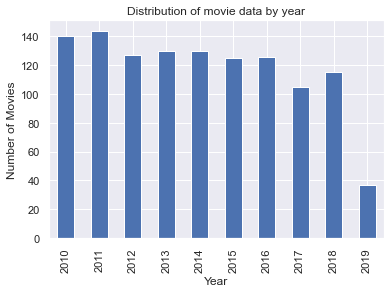

In [37]:
# Next we take a look at how our data is distributed by year.

combined_data.groupby('year_x')['movie'].count().plot(kind='bar',
                                                              legend=False,
                                                              title='Distribution of movie data by year',
                                                              ylabel="Number of Movies",
                                                              xlabel="Year")

#### Making Generes More Workable

In our analysis, we will want to extract some things based on the movie genres. However, currently multiple genres can be nested under a single movie.

In [38]:
combined_data['genres'].head(10)

1      Action,Adventure,Fantasy
2       Action,Adventure,Sci-Fi
3       Action,Adventure,Sci-Fi
6       Action,Adventure,Sci-Fi
8      Action,Adventure,Fantasy
9     Action,Adventure,Thriller
10              Action,Thriller
11     Action,Adventure,Fantasy
12     Action,Adventure,Western
13      Action,Adventure,Sci-Fi
Name: genres, dtype: object

In [39]:
genres_list = combined_data['genres'].unique()
genres_list = genres_list.tolist()

unique_genere_list = []

for i in range(len(genres_list)):
    if genres_list[i] is not None:
            unique_genere_list.extend(genres_list[i].split(','))
    else:
        pass

unique_genere_list = list(set(unique_genere_list))

In [40]:
print(len(unique_genere_list))
print(unique_genere_list)

21
['Action', 'Horror', 'Documentary', 'Music', 'War', 'Comedy', 'Western', 'Sci-Fi', 'Animation', 'Sport', 'Romance', 'Biography', 'Musical', 'Crime', 'Fantasy', 'Thriller', 'History', 'Family', 'Adventure', 'Drama', 'Mystery']


Great! So it looks like we have 21 different genres.

We want to extract what are all the possible genre types and have each one represented by a row in our data.

In [41]:
# code from https://stackoverflow.com/questions/17116814/pandas-how-do-i-split-text-in-a-column-into-multiple-rows
from pandas import Series
s = combined_data['genres'].str.split(',').apply(Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'genres' # needs a name to join
s
del combined_data['genres']
genre_data = combined_data.join(s)

In [42]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3096 entries, 1 to 4728
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3096 non-null   int64  
 1   movie              3096 non-null   object 
 2   production_budget  3096 non-null   float64
 3   domestic_gross     3096 non-null   float64
 4   worldwide_gross    3096 non-null   float64
 5   year_x             3096 non-null   object 
 6   director           3096 non-null   object 
 7   genres             3096 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 217.7+ KB


In [43]:
genre_data.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,year_x,director,genres
1,2,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,Rob Marshall,Action
1,2,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,Rob Marshall,Adventure
1,2,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,Rob Marshall,Fantasy
2,3,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,Simon Kinberg,Action
2,3,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,Simon Kinberg,Adventure


### Creating Features

Now that we have all the data we wanted combined in one place, it's time to create some additional features in this dataset for use in our analysis.

In [44]:
combined_data['profit'] = combined_data['worldwide_gross'] - combined_data['production_budget']
combined_data['percent_return'] = combined_data['worldwide_gross'] / combined_data['production_budget']

Let's create a function that checks whether the movie could be considered a success.
I use this answer from quora to determine parameters for what is considered a Flop, Average, Hit, Super Hit
or Blockbuster. https://www.quora.com/What-are-the-criteria-for-a-movie-hit-super-hit-blockbuster-and-flop

In [45]:
def movie_status_check(arg):
    status = None
    if arg < 1:
        status = 'Flop'
    elif 1 <= arg < 1.25:
        status = 'Average'
    elif 1.25 <= arg < 1.75:
        status = 'Hit'
    elif 1.75 <= arg < 2:
        status = 'Super Hit'
    else:
        status = 'Blockbuster'
    return status

In [46]:
combined_data['movie_status'] = combined_data['percent_return'].apply(movie_status_check)

In [47]:
combined_data.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,year_x,director,profit,percent_return,movie_status
1,2,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,Rob Marshall,6.350639e+08,2.546673,Blockbuster
2,3,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,Simon Kinberg,-2.002376e+08,0.427892,Flop
3,4,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015,Joss Whedon,1.072414e+09,4.243841,Blockbuster
6,7,avengers: infinity war,300000000.0,678815482.0,2.048134e+09,2018,Anthony Russo,1.748134e+09,6.827114,Blockbuster
8,9,justice league,300000000.0,229024295.0,6.559452e+08,2017,Zack Snyder,3.559452e+08,2.186484,Blockbuster


In [48]:
# We want to create the same features in our generes dataframe.
genre_data['profit'] = genre_data['worldwide_gross'] - genre_data['production_budget']
genre_data['percent_return'] = genre_data['worldwide_gross'] / genre_data['production_budget']
genre_data['movie_status'] = genre_data['percent_return'].apply(movie_status_check)

In [49]:
# Lastly, let's take a look at how many unique values we have for each of our features.

combined_data.nunique()

id                    100
movie                1167
production_budget     188
domestic_gross       1147
worldwide_gross      1168
year_x                 10
director              752
profit               1168
percent_return       1168
movie_status            5
dtype: int64

To summarize, our combined dataset contains:

* 1,167 unique movie titles
* 752 directors
* Data across 10 years
* Earlier analysis shows we also have 21 unique genres (though one movie can have multiple genres)

## Analysis

Now that we have our data combined and prepared, we begin looking into different features to extract findings.

### Correlation between how much you spend and a movie's performance

There is a strong positive correlation (0.77) between a movie's production budget and its worldwide gross box office performance. In other words, the more you spend the better revenue performance you can expect.

Furthermore, there is also a strong, albeit slightly weaker, correlation between budget and profit (0.64).

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Correlation between production budget and worldwide box office performance')

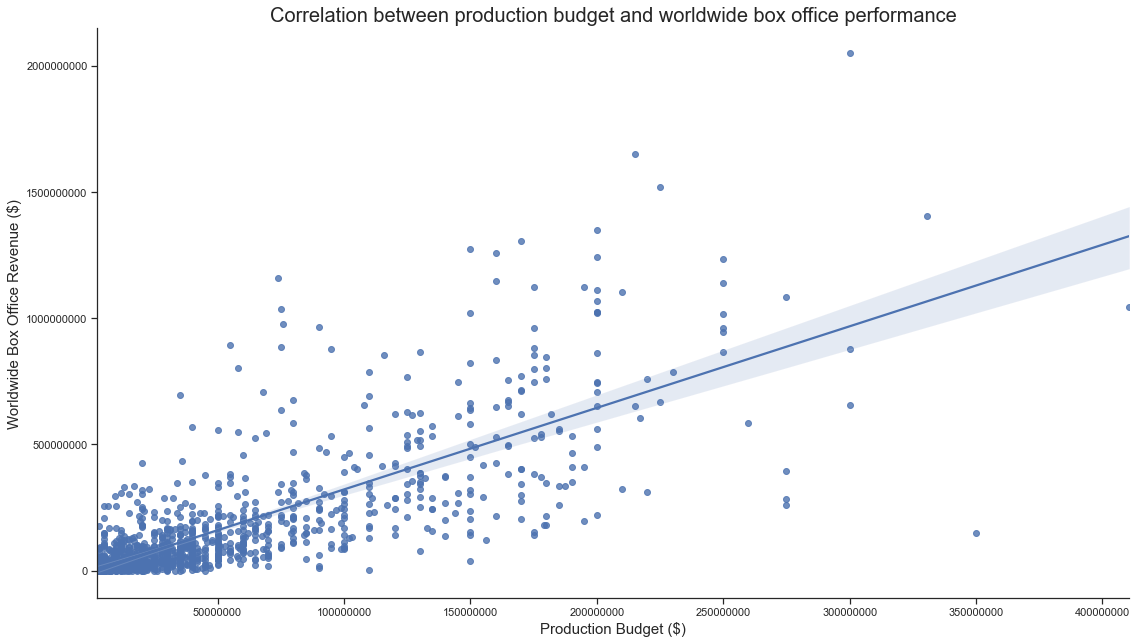

In [50]:
# Issues with sizing this graph were resolved with code from:
# https://stackoverflow.com/questions/31556424/how-do-i-change-the-plot-size-of-a-regplot-in-seaborn

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.regplot(combined_data["production_budget"],combined_data["worldwide_gross"], ax=ax)
sns.despine()

plt.ticklabel_format(style='plain', axis='both')

plt.xlabel("Production Budget ($)", fontsize=15)
plt.ylabel("Worldwide Box Office Revenue ($)", fontsize=15)
plt.title("Correlation between production budget and worldwide box office performance", fontsize=20)

In [51]:
# Calculating the correlation between production budget and worldwide_gross
combined_data["production_budget"].corr(combined_data["worldwide_gross"])

0.7682626062875523

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Correlation between production budget and movie profit')

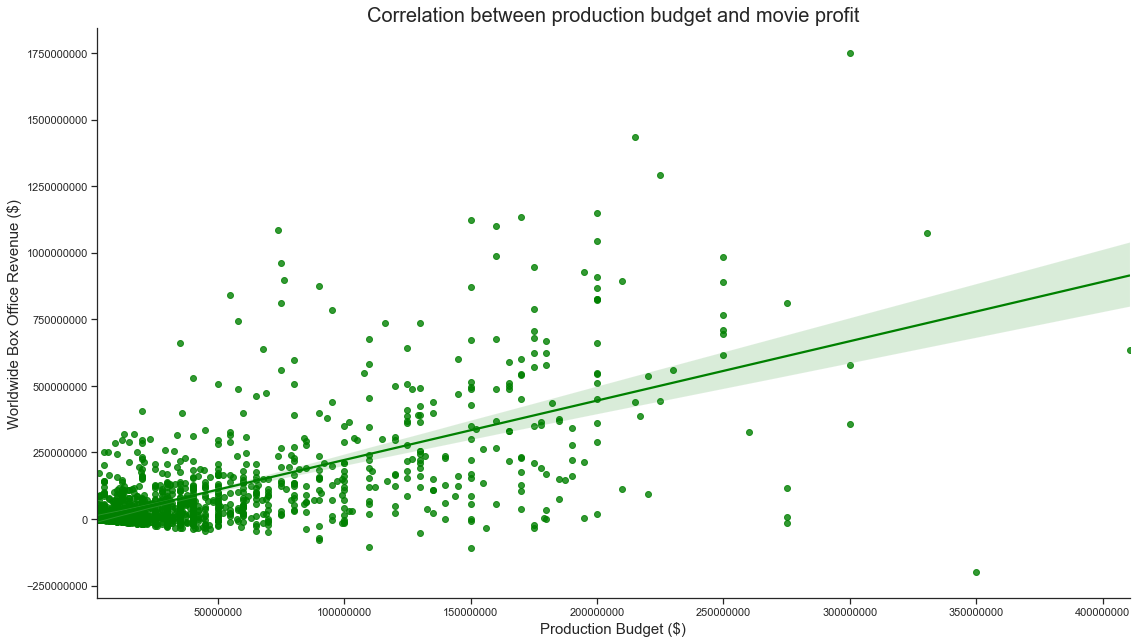

In [52]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.regplot(combined_data["production_budget"],combined_data["profit"],color='green', ax=ax)
sns.despine()

plt.ticklabel_format(style='plain', axis='both')

plt.xlabel("Production Budget ($)", fontsize=15)
plt.ylabel("Worldwide Box Office Revenue ($)", fontsize=15)
plt.title("Correlation between production budget and movie profit", fontsize=20)

In [53]:
# Calculating the correlation between production budget and profit
combined_data["production_budget"].corr(combined_data["profit"])

0.6380208058885605

In [54]:
# What is the median monetary performance at each movie status tier?
combined_data.groupby('movie_status')[['production_budget','profit','worldwide_gross']].median()

,production_budget,profit,worldwide_gross
movie_status,,,
Average,40000000.0,4025604.0,43468588.5
Blockbuster,35000000.0,105773401.0,144384926.5
Flop,20000000.0,-8968068.0,8300821.0
Hit,35000000.0,17193547.0,50505603.0
Super Hit,47500000.0,38704710.0,86204710.0


In [55]:
# Really quickly we can calculate the median return 
# for a blockbuster by dividing the worldwide_gross by the median production budget.

median_blockbuster_return = 144384926.5 / 35000000.0
median_blockbuster_return

4.125283614285714

The above shows us that a media blockbuster has a production budget of $35,000,000 and typically returns 4.13 for every dollar invested.

In [56]:
# What does the distribution of our data look like at each status tier?
combined_data.groupby('movie_status')['movie'].count()

movie_status
Average         56
Blockbuster    704
Flop           237
Hit            126
Super Hit       56
Name: movie, dtype: int64

Text(0.5, 1.0, 'How typical movie budgets translate to performance at the box office')

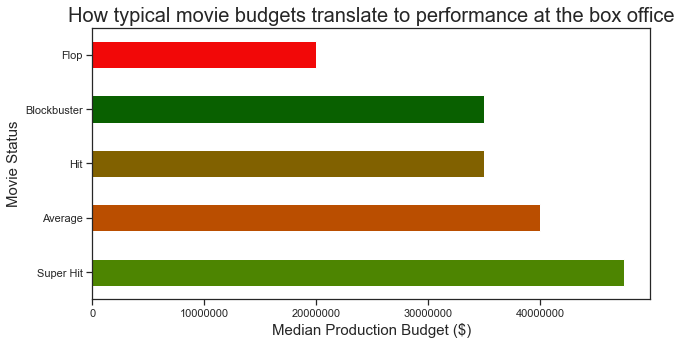

In [57]:
# Graphing median production budgets at every tier

c = ['#f20808', '#096000', '#816100', '#ba4e00', '#4d8501']
movie_status_plot = combined_data.groupby('movie_status')['production_budget'].median().sort_values()
ax = movie_status_plot.plot(
     kind='barh', stacked=True,  
     color = c,
     figsize=(10, 5))
ax.invert_yaxis()
plt.ticklabel_format(style='plain', axis='x')

plt.xlabel("Median Production Budget ($)", fontsize=15)
plt.ylabel("Movie Status", fontsize=15)
plt.title('How typical movie budgets translate to performance at the box office',fontsize=20)

### What genres do best?

On average, Animated movies had the highest worldwide gross revenue at the box office - followed by adventure and Sci-Fi movies. A similar trend was observed when looked at from a profitability standpoint.

Text(0.5, 1.0, 'Typical Revenue by Movie Genre')

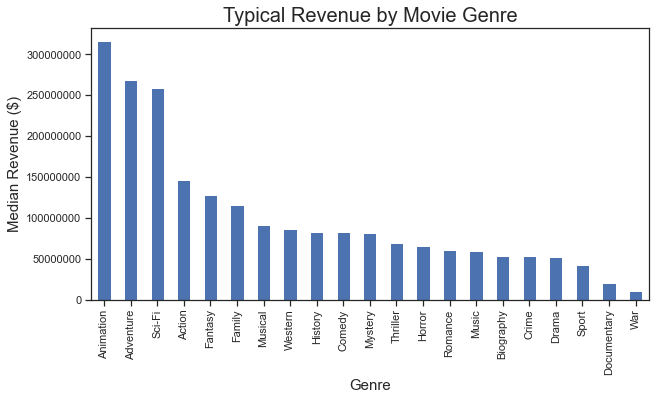

In [58]:
genres_revenue_plot = genre_data.groupby('genres')['worldwide_gross'].median().sort_values(ascending=False)
ax = genres_revenue_plot.plot(
     kind='bar',
     figsize=(10, 5))
plt.ticklabel_format(style='plain', axis='y')

plt.xlabel("Genre", fontsize=15)
plt.ylabel("Median Revenue ($)", fontsize=15)
plt.title('Typical Revenue by Movie Genre',fontsize=20)

Text(0.5, 1.0, 'Typical Profit by Movie Genre')

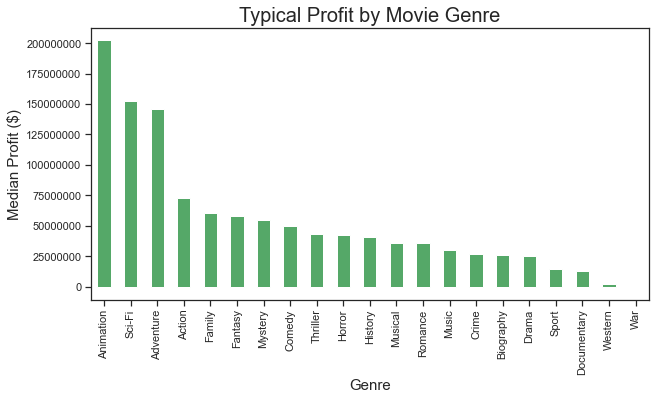

In [59]:
genres_profit_plot = genre_data.groupby('genres')['profit'].median().sort_values(ascending=False)
ax = genres_profit_plot.plot(
     kind='bar',
     figsize=(10, 5),
     color="g")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Median Profit ($)", fontsize=15)
plt.title('Typical Profit by Movie Genre',fontsize=20)

In [60]:
genre_data.groupby('genres')[['production_budget',
                              'worldwide_gross',
                              'profit']].median().sort_values(by='profit',ascending=False)

,production_budget,worldwide_gross,profit
genres,,,
Animation,90000000.0,316450194.5,202467009.0
Sci-Fi,101000000.0,258665076.5,152422018.5
Adventure,110000000.0,268268174.0,146271037.0
Action,65000000.0,146195159.0,72525156.0
Family,50500000.0,115877728.0,60222708.0
Fantasy,70000000.0,127261200.0,58041414.0
Mystery,20000000.0,81642338.5,54578986.0
Comedy,32000000.0,82332450.0,49652207.0
Thriller,25000000.0,69448704.0,42918700.0


### Which directors should you hire?

Next we look at the top and bottom 5 directors in the last 10 years in terms of how many blockbusters they were able to produce.

[Text(0.5, 0, 'Number of Blockbuster Films'), Text(0, 0.5, 'Director')]

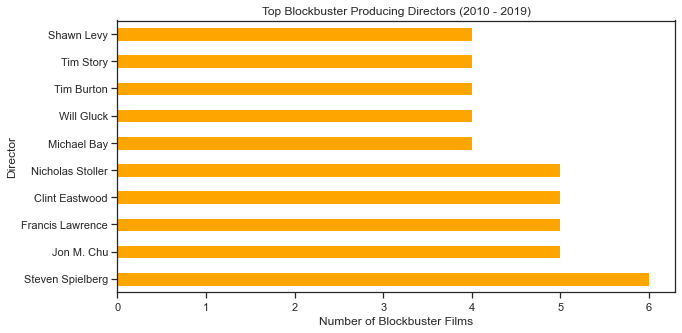

In [61]:
# Graphing the top blockbuster producing directors
top_director_plot = combined_data.query('movie_status == "Blockbuster"').groupby('director')['movie'].count().sort_values(ascending=False).head(10)
ax = top_director_plot.plot(
     kind='barh',
     title='Top Blockbuster Producing Directors (2010 - 2019)',
     figsize=(10, 5),
     color="orange")
ax.set(xlabel='Number of Blockbuster Films', ylabel='Director')

[Text(0.5, 0, 'Number of Flops'), Text(0, 0.5, 'Director')]

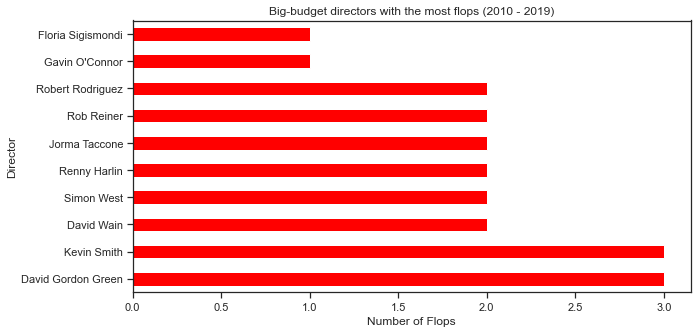

In [62]:
# Graphing the top flop producing directors

bottom_director_plot = combined_data.query('movie_status == "Flop"').groupby('director')['movie'].count().sort_values(ascending=False).head(10)

ax = bottom_director_plot.plot(
     kind='barh',
     title='Big-budget directors with the most flops (2010 - 2019)',
     figsize=(10, 5),
     color="red")
ax.set(xlabel='Number of Flops', ylabel='Director')

## Conclusions & Next Steps

We analyzed 1,179 titles (1,167 unique ones) by combdining data from The-Numbers.com and IMDB.

The analysis shows that Microsoft can expect better box office performance and profitability by investing more into each title as shown by the correlation between the production budget & worldwide gross revenue and profitability.

Animated films have seen far more success than any other feature film in our analysis. Adventure and Sci-Fi movies came in 2nd and 3rd respectively.

Steven Spielberg, Jon Chu, Francis Lawrence and Clint Eastwood produced more blockbuster films than most other directors we looked at.

### Next Steps

* Invest at least $35 million into each feature film if you expect to produce blockbusters. That is the median production budget for blockbusters in our analysis
* Focus on Animated, Action and Sci-Fi films
* Collaborate with a top-performing director like Steven Spielberg, Jon Chu, Francis Lawrence or Clint Eastwood.

testing windows env